NGAUV Nicolas

Essayer d'imaginer un système de conversion pour passer du taïwanais (taigi) romanisé  à un texte en sinogrammes.

On peut imaginer deux scenarios :
- convertir toute la chaîne de caractères directement ou
- fonctionner comme une méthode de saisie pour prédire le caractère ou le mot suivant étant donnés une séquence romanisée et un contexte gauche correspondant au texte déjà converti.

Objectif général du projet : 
- Développer un système capable de convertir automatiquement une séquence romanisée (taigi) en sinogrammes chinois, à l’aide de techniques supervisées de machine learning / deep learning.

Plan de projet détaillé :
- Phase 1 – Préparation des données
    - 1.1 Analyse du corpus JSONL
        - Charger le fichier training_sample.jsonl.
        - Vérifier que chaque ligne contient les champs "r" (romanisé) et "j" (sinogrammes).
    - 1.2 Nettoyage et normalisation
        - Supprimer ou marquer les cas ambigus ou mal alignés si nécessaire.
        - Standardiser la casse, ponctuation, caractères spéciaux.
    - 1.3 Tokenisation
        - Tokeniser les chaînes "r" en syllabes (ou en caractères).
        - Tokeniser les chaînes "j" en sinogrammes (caractères chinois individuels).
    - 1.4 Construction des vocabulaires
        - Créer deux dictionnaires :
            - token_to_index_r pour les tokens romanisés.
            - token_to_index_j pour les sinogrammes.
        - Gérer des tokens spéciaux : PAD, BOS, EOS, UNK.
- Phase 2 – Vectorisation des données
    - 2.1 Transformation en séquences d’indices
        - Chaque entrée "r" devient une séquence d’indices pour l’encodeur.
        - Chaque sortie "j" devient une séquence cible pour le décodeur.
    - 2.2 Padding et alignement
        - Appliquer un pad_sequences() pour uniformiser la longueur des séquences (entrée et sortie).
        - Ajouter des marqueurs BOS et EOS si nécessaire.
- Phase 3 – Construction du modèle
    - 3.1 Choix de l’architecture : seq2seq avec LSTM
        - Encoder :
            - Embedding + LSTM (retourne state_h, state_c)
        - Decoder :
            - Embedding + LSTM + Dense avec softmax
            - Utilisation de teacher forcing pour l’entraînement
    - 3.2 Compilation
        - Optimiseur : Adam
        - Fonction de perte : sparse_categorical_crossentropy
        - Métriques : accuracy (char-level)
- Phase 4 – Entraînement du modèle
    - 4.1 Split des données
        - Séparer en train, validation et test (ex. 80/10/10)
    - 4.2 Lancement de l’entraînement
        - Utiliser model.fit() sur les données vectorisées.
        - Ajouter un EarlyStopping si besoin.
    - 4.3 Courbes d’apprentissage
        - Afficher loss et accuracy pour train/val avec matplotlib.
- Phase 5 – Génération et inférence
    - 5.1 Implémentation d’un decode_sequence(input_seq)
        - Récupérer l’état de l’encodeur.
        - Générer un caractère à la fois, jusqu’au EOS.
    - 5.2 Conversion sur de nouvelles entrées
        - Tester la conversion sur des phrases romanisées inconnues.
- Phase 6 – Évaluation
    - 6.1 Métriques automatiques
        - Calcul du taux d’erreur caractère à caractère.
        - Calcul du score BLEU entre sorties générées et vraies chaînes.
    - 6.2 Baseline de comparaison
        - Implémenter une version simple lookup mot-à-mot pour comparer.
- Phase 7 – Documentation et analyse
    - 7.1 Analyse des erreurs
        - Étudier les erreurs fréquentes (ex. ambiguïté de syllabes).
        - Étudier la longueur des séquences vs. précision.
    - 7.2 Documentation du projet
        - Présenter les étapes, choix de modèles, résultats et perspectives.
        - Ajouter schémas, architecture, visualisations.
- Phase 8 – Scénario B : Méthode de saisie / prédiction (Second Modèle, plus complexe)
    - Implémentation autoregressive
        - Transformer le problème en prédiction d’un caractère donné un contexte sinographique + romanisé.
        - Utiliser un modèle de type GPT-like simplifié ou LSTM autoregressif.
    

Phase 1 – Préparation des données et Phase 2 – Vectorisation des données

In [20]:
import os
#os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"

import json
import re
from pathlib import Path
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# SANS STANDARDISATION

# 1. Chargement du corpus
def load_data(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line.strip())
            if "r" in obj and "j" in obj:
                data.append((obj["r"], obj["j"]))
    return data

# 2. Tokenisation
def tokenize_romanized(s):
    return s.strip().split(" ")

def tokenize_sinogrammes(s):
    return list(s.strip())  # un sinogramme = 1 caractère

# 3. Construction des vocabulaires
def build_vocab(sequences, special_tokens=["<PAD>", "<BOS>", "<EOS>", "<UNK>"]):
    vocab = set(token for seq in sequences for token in seq)
    vocab = special_tokens + sorted(vocab)
    token_to_id = {tok: idx for idx, tok in enumerate(vocab)}
    id_to_token = {idx: tok for tok, idx in token_to_id.items()}
    return token_to_id, id_to_token

# 4. Conversion en indices
def convert_to_ids(sequences, token_to_id, bos=False, eos=False):
    out = []
    for seq in sequences:
        ids = []
        if bos:
            ids.append(token_to_id["<BOS>"])
        for token in seq:
            ids.append(token_to_id.get(token, token_to_id["<UNK>"]))
        if eos:
            ids.append(token_to_id["<EOS>"])
        out.append(ids)
    return out

# 5. Main pipeline
def prepare_data(jsonl_path, maxlen_r=30, maxlen_j=30, test_size=0.2):
    data = load_data(jsonl_path)
    
    romanized_seqs = [tokenize_romanized(r) for r, _ in data]
    sinogram_seqs = [tokenize_sinogrammes(j) for _, j in data]
    
    # Vocabulaires
    tok2id_r, id2tok_r = build_vocab(romanized_seqs)
    tok2id_j, id2tok_j = build_vocab(sinogram_seqs)
    
    # Séquences en indices
    X = convert_to_ids(romanized_seqs, tok2id_r)
    y = convert_to_ids(sinogram_seqs, tok2id_j, bos=True, eos=True)
    
    # Padding
    X_pad = pad_sequences(X, maxlen=maxlen_r, padding="post", truncating="post", value=tok2id_r["<PAD>"])
    y_pad = pad_sequences(y, maxlen=maxlen_j, padding="post", truncating="post", value=tok2id_j["<PAD>"])
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=test_size, random_state=42)
    
    return {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "tok2id_r": tok2id_r, "id2tok_r": id2tok_r,
        "tok2id_j": tok2id_j, "id2tok_j": id2tok_j
    }



In [22]:
# AVEC STANDARDISATION : Standardiser la casse, ponctuation, caractères spéciaux

# --- Nettoyage et normalisation ---
def clean_romanized(text):
    text = text.lower()  # standardiser la casse
    text = re.sub(r"[^\w\s]", "", text)  # supprimer ponctuation occidentale
    text = re.sub(r"\s+", " ", text).strip()  # normaliser les espaces
    return text

def clean_sinogram(text):
    # Supprimer ponctuation chinoise + occidentale + symboles divers
    punctuations = r"[，。！？、：；「」『』《》〈〉（）(){}【】\[\]“”‘’\",\.!?;:…\-—~·•◦→←«»]"
    text = re.sub(punctuations, "", text)
    text = re.sub(r"\s+", "", text)  # supprimer les espaces
    return text.strip()

# --- Chargement du corpus ---
def load_data(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line.strip())
            if "r" in obj and "j" in obj:
                romanized = clean_romanized(obj["r"])
                sinograms = clean_sinogram(obj["j"])
                if romanized and sinograms:
                    data.append((romanized, sinograms))
    return data

# --- Tokenisation ---
def tokenize_romanized(s):
    return s.strip().split(" ")

def tokenize_sinogrammes(s):
    return list(s.strip())  # un sinogramme = un caractère

# --- Construction des vocabulaires ---
def build_vocab(sequences, special_tokens=["<PAD>", "<BOS>", "<EOS>", "<UNK>"]):
    vocab = set(token for seq in sequences for token in seq)
    vocab = special_tokens + sorted(vocab)
    token_to_id = {tok: idx for idx, tok in enumerate(vocab)}
    id_to_token = {idx: tok for tok, idx in token_to_id.items()}
    return token_to_id, id_to_token

# --- Conversion en indices ---
def convert_to_ids(sequences, token_to_id, bos=False, eos=False):
    out = []
    for seq in sequences:
        ids = []
        if bos:
            ids.append(token_to_id["<BOS>"])
        for token in seq:
            ids.append(token_to_id.get(token, token_to_id["<UNK>"]))
        if eos:
            ids.append(token_to_id["<EOS>"])
        out.append(ids)
    return out

# --- Pipeline complet ---
def prepare_data(jsonl_path, maxlen_r=30, maxlen_j=30, test_size=0.2):
    data = load_data(jsonl_path)
    
    romanized_seqs = [tokenize_romanized(r) for r, _ in data]
    sinogram_seqs = [tokenize_sinogrammes(j) for _, j in data]
    
    # Vocabulaires
    tok2id_r, id2tok_r = build_vocab(romanized_seqs)
    tok2id_j, id2tok_j = build_vocab(sinogram_seqs)
    
    # Séquences en indices
    X = convert_to_ids(romanized_seqs, tok2id_r)
    y = convert_to_ids(sinogram_seqs, tok2id_j, bos=True, eos=True)
    
    # Padding
    X_pad = pad_sequences(X, maxlen=maxlen_r, padding="post", truncating="post", value=tok2id_r["<PAD>"])
    y_pad = pad_sequences(y, maxlen=maxlen_j, padding="post", truncating="post", value=tok2id_j["<PAD>"])
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=test_size, random_state=42)
    
    return {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "tok2id_r": tok2id_r, "id2tok_r": id2tok_r,
        "tok2id_j": tok2id_j, "id2tok_j": id2tok_j
    }


In [23]:
data = prepare_data("taigi_ime_data.jsonl")

# Dimensions
print("Taille X_train :", data["X_train"].shape)
print("Taille y_train :", data["y_train"].shape)

# Exemple de décodage
r_tokens = [data["id2tok_r"][id] for id in data["X_train"][0] if id != data["tok2id_r"]["<PAD>"]]
j_tokens = [data["id2tok_j"][id] for id in data["y_train"][0] if id not in (data["tok2id_j"]["<PAD>"], data["tok2id_j"]["<EOS>"])]
print("Romanisé :", " ".join(r_tokens))
print("Sinogrammes :", "".join(j_tokens))

Taille X_train : (64750, 30)
Taille y_train : (64750, 30)
Romanisé : siong1sin3 it4ting7 e7 sing5kong1
Sinogrammes : <BOS>相信一定會成功


In [24]:
#data = prepare_data("training_sample.jsonl")

# Reconstruction des séquences pour stats
def count_frequencies(token_lists):
    return Counter(tok for seq in token_lists for tok in seq)

# Récupérer les tokens depuis les ID (données brutes, sans padding)
romanized_seqs = [
    [data["id2tok_r"][id] for id in row if id != data["tok2id_r"]["<PAD>"]]
    for row in data["X_train"]
]

sinogram_seqs = [
    [data["id2tok_j"][id] for id in row
     if id not in (data["tok2id_j"]["<PAD>"], data["tok2id_j"]["<BOS>"], data["tok2id_j"]["<EOS>"])]
    for row in data["y_train"]
]

# Comptage des fréquences
freq_r = count_frequencies(romanized_seqs)
freq_j = count_frequencies(sinogram_seqs)

# Afficher les plus fréquents
print("🎯 Top 10 romanisé :", freq_r.most_common(10))
print("🎯 Top 10 sinogrammes :", freq_j.most_common(10))
print(f"📚 Vocabulaire romanisé : {len(data['tok2id_r'])} tokens")
print(f"📚 Vocabulaire sinogrammes : {len(data['tok2id_j'])} caractères")

🎯 Top 10 romanisé : [('e5', 24995), ('si7', 6550), ('u7', 5202), ('gua2', 5008), ('kah4', 4298), ('bo5', 3648), ('ti7', 3575), ('lang5', 3106), ('hoo7', 2995), ('i1', 2828)]
🎯 Top 10 sinogrammes : [('的', 23739), ('是', 11970), ('一', 10504), ('人', 8982), ('仔', 8707), ('有', 8641), ('無', 7633), ('h', 7579), ('來', 6708), ('n', 6411)]
📚 Vocabulaire romanisé : 28888 tokens
📚 Vocabulaire sinogrammes : 3474 caractères


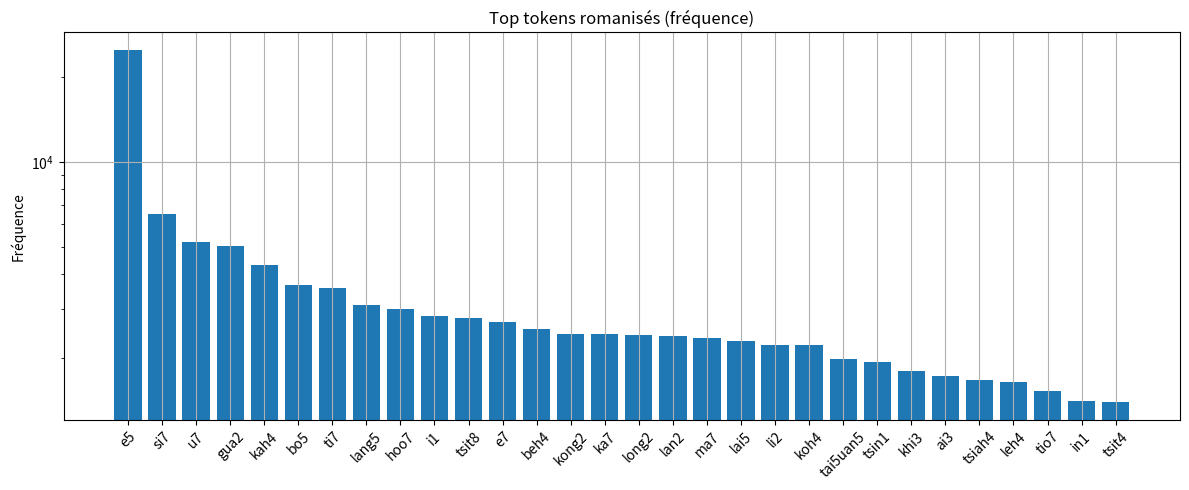

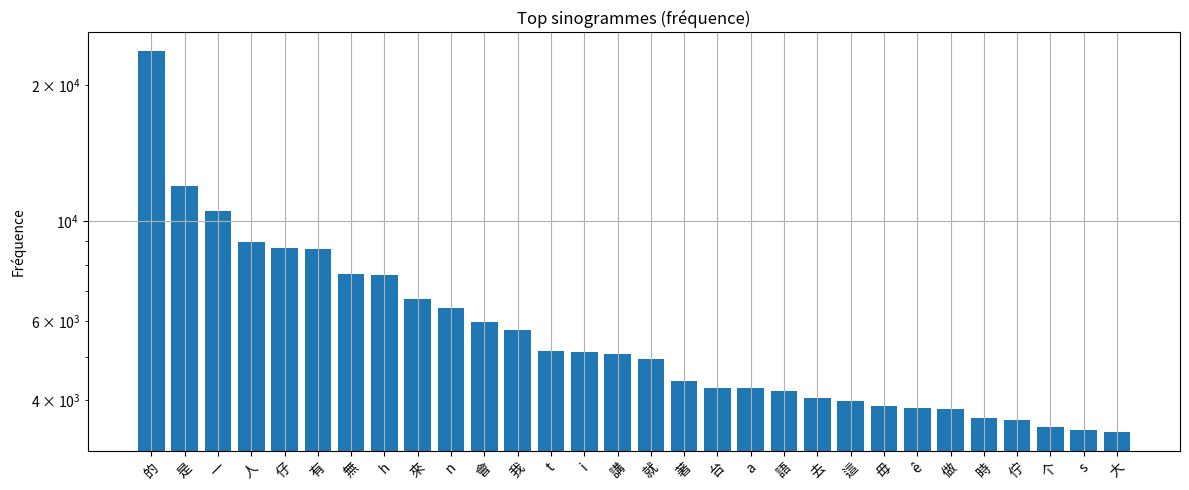

In [25]:
def plot_token_frequencies(counter, title, max_tokens=30):
    tokens, freqs = zip(*counter.most_common(max_tokens))
    plt.figure(figsize=(12, 5))
    plt.bar(tokens, freqs)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Fréquence")
    plt.yscale("log")  # Log pour lisibilité si nécessaire
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_token_frequencies(freq_r, "Top tokens romanisés (fréquence)")
plot_token_frequencies(freq_j, "Top sinogrammes (fréquence)")

In [26]:
# Exemple d'entrée romanisée et de sortie
example_idx = 0
r_example = [data["id2tok_r"][id] for id in data["X_train"][example_idx] if id != data["tok2id_r"]["<PAD>"]]
j_example = [data["id2tok_j"][id] for id in data["y_train"][example_idx] if id not in (data["tok2id_j"]["<PAD>"], data["tok2id_j"]["<BOS>"], data["tok2id_j"]["<EOS>"])]

print("Romanisé :", " ".join(r_example))
print("Sinogrammes :", "".join(j_example))


Romanisé : siong1sin3 it4ting7 e7 sing5kong1
Sinogrammes : 相信一定會成功


Phase 3 - Construction du modèle et Phase 4 - Entrainement du modèle

In [27]:
def build_seq2seq_attention_model(
    input_vocab_size,
    target_vocab_size,
    embedding_dim=128,
    encoder_units=256,
    decoder_units=256,
    maxlen_input=30,
    maxlen_target=30
):
    # ----- Encoder -----
    encoder_inputs = keras.Input(shape=(maxlen_input,), name="encoder_inputs")

    # Embedding + Encoder LSTM
    #enc_emb = layers.Embedding(input_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    enc_emb = layers.Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = layers.LSTM(encoder_units, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

    # ----- Decoder -----
    decoder_inputs = keras.Input(shape=(maxlen_target,), name="decoder_inputs")

    # Embedding + Decoder LSTM
    #dec_emb = layers.Embedding(target_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    dec_emb = layers.Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = layers.LSTM(decoder_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # ----- Attention -----
    #attention_layer = layers.Attention(name="attention")
    attention_layer = layers.AdditiveAttention(name="attention")

    attention_output = attention_layer([decoder_outputs, encoder_outputs])

    # Concaténer l'attention et les sorties du décodeur
    concat_attention = layers.Concatenate(axis=-1)([decoder_outputs, attention_output])

    # Dense couche finale
    dense = layers.TimeDistributed(layers.Dense(target_vocab_size, activation="softmax"))
    output = dense(concat_attention)

    # ----- Modèle final -----
    model = keras.Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [28]:
def split_decoder_inputs_outputs(y, pad_token=0):
    decoder_input = y[:, :-1]
    decoder_output = y[:, 1:]
    return decoder_input, decoder_output


In [29]:
# Prépare les données
decoder_input_train, decoder_target_train = split_decoder_inputs_outputs(data["y_train"])
decoder_input_test, decoder_target_test = split_decoder_inputs_outputs(data["y_test"])

# Paramètres
input_vocab_size = len(data["tok2id_r"])
target_vocab_size = len(data["tok2id_j"])
maxlen_input = data["X_train"].shape[1]
#maxlen_target = data["y_train"].shape[1]
maxlen_target = data["y_train"].shape[1] - 1


# Modèle
model = build_seq2seq_attention_model(
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    maxlen_input=maxlen_input,
    maxlen_target=maxlen_target
)

# Résumé
model.summary()

# Entraînement
early_stop = EarlyStopping(patience=3, restore_best_weights=True)    # Early Stopping
history = model.fit(
    [data["X_train"], decoder_input_train],
    decoder_target_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 30, 128)   │  3,697,664 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 29, 128)   │    444,672 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 256), │    394,240 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 29, 256), │    394,240 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 29, 256)   │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 29, 512)   │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 29, 3474)  │  1,782,162 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,713,234 (25.61 MB)

 Trainable params: 6,713,234 (25.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1600/1619 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - accuracy: 0.6032 - loss: 2.7870

KeyboardInterrupt: 

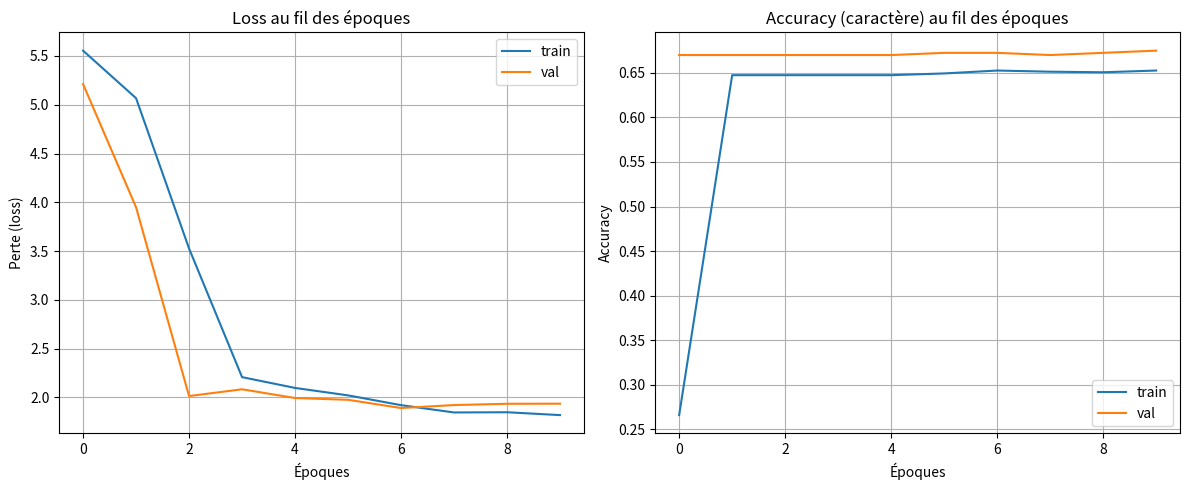

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Sous-plot 1 : loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Loss au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Perte (loss)")
    plt.legend()
    plt.grid(True)

    # Sous-plot 2 : accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy (caractère) au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Utilisation
plot_learning_curves(history)
